In [22]:
import pygame
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, product

In [23]:
WIDTH, HEIGHT = 800, 600
FIELD = pygame.Rect(50, 50, WIDTH-100, HEIGHT-100)
ROBOT_RADIUS = 20
WHEEL_RADIUS = 5
TARGET_RADIUS = 10

In [24]:
def actionMatrix(action):
    control_values = [0.0, 0.0, 0.0]
    # Mapping actions to control values
    if action == 0:
        control_values = [1.0, 0.0, 0.0]  # up
    elif action == 1:
        control_values = [-1.0, 0.0, 0.0]  # down
    elif action == 2:
        control_values = [0.0, 1.0, 0.0]  # right
    elif action == 3:
        control_values = [0.0, -1.0, 0.0]  # left
    elif action == 4:
        control_values = [1.0, 1.0, 0.0] # up-right
    elif action == 5:
        control_values = [1.0, -1.0, 0.0] # up-left
    elif action == 6:
        control_values = [-1.0, 1.0, 0.0] # down-right
    elif action == 7:
        control_values = [-1.0, -1.0, 0.0] # down-left
    else:
        control_values = [0.0, 0.0, 0.0]  # error

    return control_values

In [25]:
def get_state(robot_pose, target_pos, target_vel):
    # Determine the relative position of the target with respect to the robot, considering orientation
    x_robot, y_robot, theta_robot = robot_pose
    x_target, y_target = target_pos

    # Calculate the relative position in the robot's local coordinate system
    relative_x = (x_target - x_robot) * math.cos(math.radians(theta_robot)) - (y_target - y_robot) * math.sin(math.radians(theta_robot))
    relative_y = (x_target - x_robot) * math.sin(math.radians(theta_robot)) + (y_target - y_robot) * math.cos(math.radians(theta_robot))

    if relative_y > 0:
        if abs(relative_x) < ROBOT_RADIUS:
            # Ball in front of the robot
            state_position = 0
        elif relative_x < 0:
            # Ball left in front of the robot
            state_position = 1
        else:
            # Ball right in front of the robot
            state_position = 2
    else:
        if relative_x < 0:
            # Ball left behind the robot
            state_position = 3
        else:
            # Ball right behind the robot
            state_position = 4

    # Discretize the target velocity
    target_vel_x, target_vel_y = target_vel

    if target_vel_x >= 0.2:
        velocity_category = 0
    elif -0.2 <= target_vel_x < 0.2:
        velocity_category = 1
    elif target_vel_x < -0.2:
        velocity_category = 2

    # Map the combination of position and velocity to an integer state value (0 to 15)
    state = state_position * 3 + velocity_category
    return state

In [26]:
def distance(pose1, pose2):
    return math.sqrt((pose1[0] - pose2[0])**2 + (pose1[1] - pose2[1])**2)
    
def clip(value, min_val = -1, max_val = 1):
    return max(min(value, max_val), min_val)

def update_pose(robot_pose, omega_0, omega_1, omega_2, step_size=1.0):
    [x,y,theta]=robot_pose
    omega_0 = clip(omega_0)
    omega_1 = clip(omega_1)
    omega_2 = clip(omega_2)
    
    R = 0.5
    # d = 1.0
    V_x = R * (omega_0 * math.cos(math.radians(60)) +
               omega_1 * math.cos(math.radians(180)) +
               omega_2 * math.cos(math.radians(300)))
    V_y = R * (omega_0 * math.sin(math.radians(60)) +
               omega_1 * math.sin(math.radians(180)) +
               omega_2 * math.sin(math.radians(300)))
    V_x_rotated = (V_x * math.cos(math.radians(theta)) - 
                   V_y * math.sin(math.radians(theta)))
    V_y_rotated = (V_x * math.sin(math.radians(theta)) + 
                   V_y * math.cos(math.radians(theta)))

    omega = omega_0 + omega_1 + omega_2
    x_prime = x + V_x_rotated * step_size
    y_prime = y + V_y_rotated * step_size

    theta_prime = theta + omega * step_size
    theta_prime = theta_prime % 360
    return x_prime, y_prime, theta_prime

def update_target_pose(target_pos, target_vel):
    target_x, target_y = target_pos
    target_vx, target_vy = target_vel
    target_x += target_vx * 0.1
    target_y += target_vy * 0.1
    target_vel = [target_vx, target_vy]  # assume constant velocity
    return [target_x, target_y], target_vel

In [27]:
def compute_reward(robot_pose, target_pos):

    [x,y,theta]= robot_pose
    current_distance_to_target = distance([x, y], target_pos)
    
    if not FIELD.collidepoint(x, y):
        # Penalize the robot for going out of bounds
        return -1
    elif current_distance_to_target < TARGET_RADIUS:
        # Reward the robot for reaching the target
        return  10
    else:
        return -0.01 


In [28]:
# Testing the agent
test_rewards = []
class Policy(nn.Module):
	def __init__(self, input_size, hidden_size, hidden_size2, output_size):
		super(Policy, self).__init__()
		self.linear1 = nn.Linear(input_size, hidden_size)
		self.linear2 = nn.Linear(hidden_size, hidden_size2)
		self.linear3 = nn.Linear(hidden_size2, output_size)
		
	def forward(self, state):
		x = F.relu(self.linear1(state))
		x = F.relu(self.linear2(x))	
		x = F.softmax(self.linear3(x), dim=-1)
		
		return x
input_size = 2
hidden_size = 256
hidden_size2 = 128
actions = [0, 1, 2, 3, 4, 5, 6, 7]
output_size = len(actions)
for episode in range(50):
    score = 0
    robot_pose = [random.randint(FIELD.left, FIELD.right), random.randint(FIELD.top, FIELD.bottom), random.randint(0, 359)]
    target_pos = [random.randint(FIELD.left, FIELD.right), random.randint(FIELD.top, FIELD.bottom)]
    target_vel = [random.uniform(0.2, 0.6), random.uniform(-0.6, 0.6)]
    step = 0
    while step < 1000:
        x, y, theta = robot_pose
        state = torch.FloatTensor([x, y])
        policy_network = Policy(input_size, hidden_size, hidden_size2, output_size)  # Initialize policy network
        policy_network.load_state_dict(torch.load("policy.pth"))
        policy_network.eval()  # Set the network to evaluation mode
        action_probs = policy_network(state)
        action_distribution = torch.distributions.Categorical(action_probs)
        action = action_distribution.sample()

        # Perform the action in the environment
        omega_0, omega_1, omega_2 = actionMatrix(action.item())

        robot_pose_prime = update_pose([x, y, theta], omega_0, omega_1, omega_2, 0.1)
        target_pos_prime, target_vel_prime = update_target_pose(target_pos, target_vel)
        reward = compute_reward(robot_pose_prime, target_pos_prime)
        robot_pose = robot_pose_prime
        target_pos = target_pos_prime
        target_vel = target_vel_prime
        score += reward
        step += 1
    test_rewards.append(score)


In [29]:
# Print the results
# print("Training rewards:", training_rewards)
print("Test rewards:", test_rewards)
print("Average test reward:", np.mean(test_rewards))
print("Standard deviation of test reward:", np.std(test_rewards))

Test rewards: [-9.999999999999831, -9.999999999999831, -471.3399999999997, 1761.7700000000073, -9.999999999999831, -9.999999999999831, -229.7799999999999, -9.999999999999831, -9.999999999999831, -447.57999999999583, -9.999999999999831, -649.54, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -566.379999999997, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.999999999999831, -9.9999999999998

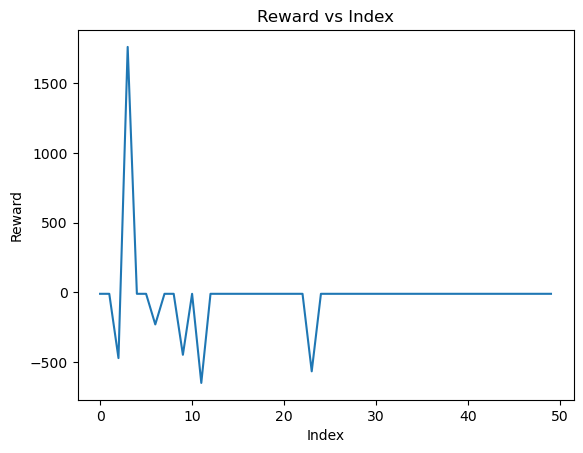

In [30]:
import matplotlib.pyplot as plt

# Create a list of indices
indices = list(range(len(test_rewards)))

# Create the plot
plt.plot(indices, test_rewards)

# Add title and labels
plt.title('Reward vs Index')
plt.xlabel('Index')
plt.ylabel('Reward')

# Show the plot
plt.show()